# Mosaicing

Mosaicing is the process of putting together images that are of the same part of the sky, but only have partial overlap.  We can use it to build up images much bigger than our CCD.

In [1]:
%matplotlib inline
import pylab as pl
import numpy as np
pl.rcParams['image.origin'] = 'lower'
pl.style.use('dark_background')

In [2]:
fullimage = np.zeros([512,512])
np.random.seed(1)
star_x,star_y = np.random.rand(25)*512, np.random.rand(25)*512
amp = np.random.rand(25)*100
yi,xi = np.indices(fullimage.shape)
for x,y,a in zip(star_x,star_y,amp):
    fullimage += np.exp(-((xi-x)**2 + (yi-y)**2)/(2*5**2)) * a

For this lecture, I'm using a made-up sky image with artificial stars.  The simulated sky looks like this:

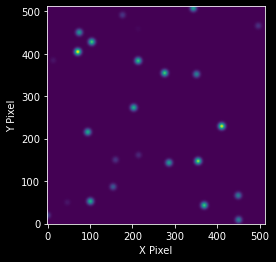

In [3]:
_=pl.imshow(fullimage); _=pl.xlabel("X Pixel"); _=pl.ylabel("Y Pixel")

In [4]:
im1 = fullimage[128:,128:]
im2 = fullimage[:-128,:-128]

For the demonstration, we're using two images that each cover part of our fake sky.


You can see that `im1` is to the upper right and `im2` is to the lower left by the three-star asterism in the top right of `im2`

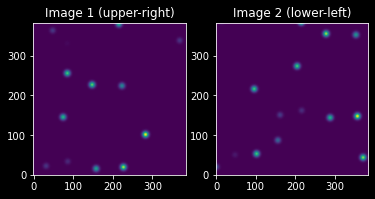

In [5]:
_=pl.subplot(1,2,1).imshow(im1); _=pl.title("Image 1 (upper-right)")
_=pl.subplot(1,2,2).imshow(im2); _=pl.title("Image 2 (lower-left)")

For the demonstration, we're using two images that each cover part of our fake sky.


You can see that `im1` is to the upper right and `im2` is to the lower left by the three-star asterism in the top right of `im2`

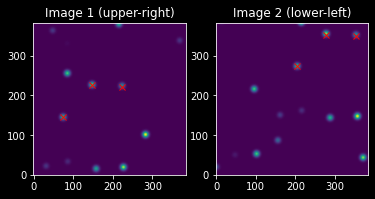

In [6]:
_=pl.subplot(1,2,1).imshow(im1); pl.plot([148, 75, 224], [225, 145, 221], 'rx'); _=pl.title("Image 1 (upper-right)")
_=pl.subplot(1,2,2).imshow(im2); pl.plot([148+128, 75+128, 224+128], [225+128, 145+128, 221+128], 'rx'); _=pl.title("Image 2 (lower-left)")

We need to measure the location of one of those stars in both images.  It must be the *same star*, so be sure you get your star identification right!

I picked the one at about 280,350 in `im2`:

In [7]:
xc2,yc2=280,350
cutout2=im2[yc2-20:yc2+20, xc2-20:xc2+20]

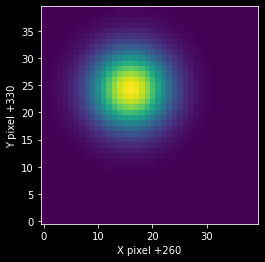

In [8]:
_=pl.imshow(cutout2)
_=pl.xlabel("X pixel +260")
_=pl.ylabel("Y pixel +330")

and 150.220 in `im1`:

In [9]:
xc1,yc1 = 150,220
cutout1 = im1[yc1-20:yc1+20, xc1-20:xc1+20]

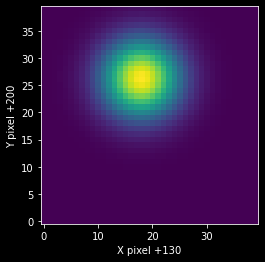

In [10]:
_=pl.imshow(cutout1)
_=pl.xlabel("X pixel +130")
_=pl.ylabel("Y pixel +200")

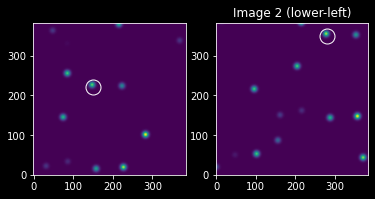

In [11]:
_=pl.subplot(1,2,1).imshow(im1); pl.plot(xc1,yc1,'wo',
                                       markerfacecolor='none',mec='white',
                                       markersize=15)
_=pl.subplot(1,2,2).imshow(im2); pl.plot(xc2,yc2,'wo',
                                       mfc='none',mec='white',
                                       markersize=15)
_=pl.title("Image 1 (upper-right)")
_=pl.title("Image 2 (lower-left)")

Their centroid locations are:

In [12]:
yi,xi = np.indices([40,40]) # cutout1.shape
xcen1 = (xi*cutout1).sum()/cutout1.sum() + xc1-20
ycen1 = (yi*cutout1).sum()/cutout1.sum() + yc1-20
xcen2 = (xi*cutout2).sum()/cutout2.sum() + xc2-20
ycen2 = (yi*cutout2).sum()/cutout2.sum() + yc2-20
xcen1, ycen1, xcen2, ycen2

(147.87628256885347, 226.18216520235532, 275.8833503363088, 354.2223864877351)

Note the `+ xc1 - 20`, etc, on the right side: this is the correction needed because we cut out the centroid image from the parent image.  The bottom-left corner is at `xc1-20, yc1-20`.

The coordinates we just calculated are relative to their respective images.  How do we stitch them together?

We need a canvas big enough to hold both.

In [13]:
im1.shape, im2.shape

((384, 384), (384, 384))

If there's no overlap between the two, we need a 384+384 = 768 square image to hold both.  We don't actually need a canvas that big, but we'll start there.

In [14]:
# I set everything to NaN so it shows up as white in display
bigim1 = np.zeros([768,768])*np.nan
bigim2 = np.zeros([768,768])*np.nan
# I made two "bigim"s so we can look at each in turn

Now, what are the coordinates of the original images in the context of the bigger image?

We can start simple and put `im2` in the bottom left.  Then, the coordinates in the `im2` frame are the same as coordinates in the `bigimage` frame.

The coordinates for `im1` are more complicated: the star's position in `im1`, x1=148, y1=226, corresponds to x2=276, y2=354.  If we subtract these, x2-x1,y2-y1=128,128, we get the coordinate of the bottom-left part of `im1` in `bigim` coordinates.

In [15]:
blx_im1,bly_im1 = int(xcen2-xcen1), int(ycen2-ycen1)
blx_im1,bly_im1 

(128, 128)

Let's look at this in practice to see what it means...

In [16]:
# first, put im2 in the bottom-left of 'bigimage'
bigim2[0:im2.shape[0], 0:im2.shape[1]] = im2

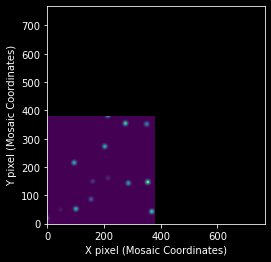

In [17]:
_=pl.imshow(bigim2)
_=pl.xlabel("X pixel (Mosaic Coordinates)")
_=pl.ylabel("Y pixel (Mosaic Coordinates)")

Next, let's do the same for `im1`, whose bottom-left corner is (128,128)

In [18]:
# then put im1 in the right spot:
bigim1[bly_im1:bly_im1+im1.shape[0],
       blx_im1:blx_im1+im1.shape[1]] = im1

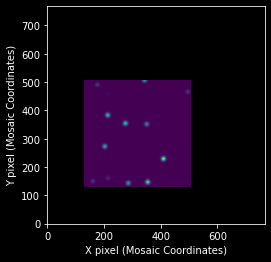

In [19]:
pl.imshow(bigim1)
_=pl.xlabel("X pixel (Mosaic Coordinates)")
_=pl.ylabel("Y pixel (Mosaic Coordinates)")

We now have the two images in the same coordinate system:

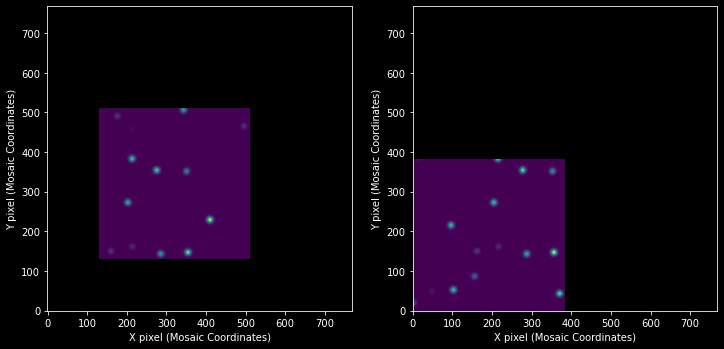

In [20]:
pl.figure(figsize=(12,6))
pl.subplot(1,2,1).imshow(bigim1)
_=pl.xlabel("X pixel (Mosaic Coordinates)")
_=pl.ylabel("Y pixel (Mosaic Coordinates)")
pl.subplot(1,2,2).imshow(bigim2)
_=pl.xlabel("X pixel (Mosaic Coordinates)")
_=pl.ylabel("Y pixel (Mosaic Coordinates)")

How do we average?  Note that there is an _overlap_ region where we are actually adding two numbers, so we have to divide by two, and non-overlap regions, where there's nothing to average.  If we just divide by two, we get the wrong answer!

This is easy to see if we add a background to the image:

In [21]:
bigim1 = bigim1 + 100
bigim2 = bigim2 + 100
bigimwrong = (np.nan_to_num(bigim1) + np.nan_to_num(bigim2))/2

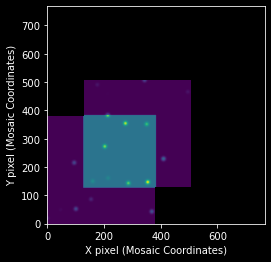

In [22]:
bigimwrong[bigimwrong == 0] = np.nan
pl.imshow(bigimwrong)
_=pl.xlabel("X pixel (Mosaic Coordinates)")
_=pl.ylabel("Y pixel (Mosaic Coordinates)")

That pale-green region is twice as bright as the surroundings!  Oops.

The right way requires taking a _weighted average_.  We do this by computing the number of counts per pixel:

In [23]:
counts1 = np.isfinite(bigim1).astype('int')
counts2 = np.isfinite(bigim2).astype('int')

These "counts" images show where the images live in the big canvas:

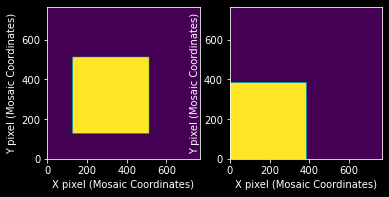

In [24]:
pl.subplot(1,2,1).imshow(counts1)
_=pl.xlabel("X pixel (Mosaic Coordinates)")
_=pl.ylabel("Y pixel (Mosaic Coordinates)")
pl.subplot(1,2,2).imshow(counts2)
_=pl.xlabel("X pixel (Mosaic Coordinates)")
_=pl.ylabel("Y pixel (Mosaic Coordinates)")

Note that if we *add* these, we see there are some places where one image contributes, and some places where two images contribute to the final mosaic:

In [25]:
totalcounts = counts1+counts2

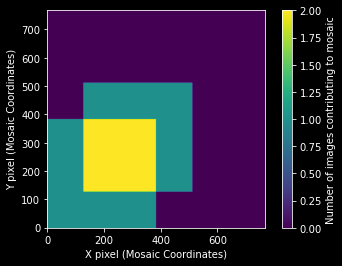

In [26]:
pl.imshow(totalcounts)
cb=pl.colorbar()
cb.set_label("Number of images contributing to mosaic")
_=pl.xlabel("X pixel (Mosaic Coordinates)")
_=pl.ylabel("Y pixel (Mosaic Coordinates)")

So if we want our mosaic to be the *average* of the inputs, we need to sum them, then divide by the number of images that went into the sum:

In [27]:
bigim = (np.nan_to_num(bigim1)+np.nan_to_num(bigim2)) / (totalcounts)
# then, we set the "blank" pixels to nan again
# (you can ignore the divide-by-zero errors because we're setting the divided-by-zero pixels to nan anyway)
bigim[(totalcounts) == 0] = np.nan

<ipython-input-27-ab7fadbaef68>:1: RuntimeWarning: invalid value encountered in true_divide
  bigim = (np.nan_to_num(bigim1)+np.nan_to_num(bigim2)) / (totalcounts)


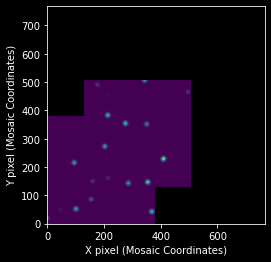

In [28]:
# for display, I'm setting zeros to nan again
bigim[bigim == 0] = np.nan
pl.imshow(bigim)
_=pl.xlabel("X pixel (Mosaic Coordinates)")
_=pl.ylabel("Y pixel (Mosaic Coordinates)")

you can see that the image is bigger than it needs to be, but we have our mosaic now!

Note that the approach we took:
```
bigim = (np.nan_to_num(bigim1) + np.nan_to_num(bigim2))/(totalcounts)
```
is equivalent to:
```
bigim = np.nanmean(np.array([bigim1, bigim2]), axis=0)
```

That latter approach - taking the mean along a third axis - is the best way to proceed if you have lots of images.

We can crop our image down just by cutting at the top-right corner:

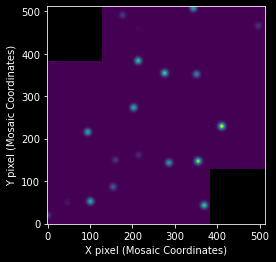

In [29]:
pl.imshow(bigim[:512,:512])
_=pl.xlabel("X pixel (Mosaic Coordinates)")
_=pl.ylabel("Y pixel (Mosaic Coordinates)")

The approach outlined in this document is what we'll use to make mosaics from the data we obtained.

Note that there can be other operations needed to make very high-quality mosaics, such as image rotation, sub-pixel alignment, and background matching.   These are all "second-order" effects (i.e., less important), so we'll only cover them if you get this far and really need them.

end of alignment -> mosaicing.